In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl

plt.rcParams['figure.figsize'] = [10, 4]
writervideo = matplotlib.animation.FFMpegWriter(fps=30)

import numpy as np
import pandas as pd

from numba import njit
import timeit
import random
from scipy.spatial import KDTree, cKDTree
from scipy.stats import linregress
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
import joblib
from tqdm import tqdm
import pims

import trackpy as tp
tp.quiet()

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

In [2]:
show_verb = False
save_verb = True

# Import data

In [3]:
data = pims.open('../data/video/movie.mp4')
rawTrajs = pd.read_csv("../data/csv/Processed_data2.csv")

17:27:11 [WARNING] deprecated pixel format used, make sure you did set range correctly


In [4]:
red_particle_idx = 17
rawTrajs.loc[rawTrajs.particle!=red_particle_idx, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle==red_particle_idx, ["color"]] = "#FF0000"
colors = rawTrajs.loc[rawTrajs.frame==0, 'color'].values

nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")

nDrops:50
nFrames:32000 --> 3200.00 s


In [ ]:
df = rawTrajs.loc[(rawTrajs.frame == 0) , ["x", "y", "color"]]
fig, ax = plt.subplots(1,1)
ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 150)
ax.imshow(data[0])
if save_verb: plt.savefig("../results/location_example.png", dpi=500, bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
fig = plt.figure()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = rawTrajs.loc[(rawTrajs.frame == frame) & (rawTrajs.particle == red_particle_idx) , ["x","y","color"]]
    graph.set_offsets(df)
    graph.set_edgecolor(df.color)
    graph2.set_data(data[frame])
    title.set_text('frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('frame = 0')
df = rawTrajs.loc[(rawTrajs.frame == 0) & (rawTrajs.particle == red_particle_idx), ["x","y","color"]]

graph = ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 150)

graph2 = ax.imshow(data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, 100, interval = 5, blit=False)
if 0: ani.save(f'../results/video/try.mp4', dpi=500, writer=writervideo)
if 0: 
    plt.show()
else:
    plt.close()

# Trajectory Smoothing

Smoothing of the trajectory using a Savgol Filter in order to drop the noise due to the tracking procedure

In [5]:
smoothTrajs = rawTrajs.copy()

# Parameters of the Savgol Filter to smooth the trajectories
windLen = 30
orderofPoly = 2
for i in range(nDrops):
    smoothTrajs.loc[smoothTrajs.particle == i, "x"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].x.values, windLen, orderofPoly)
    smoothTrajs.loc[smoothTrajs.particle == i, "y"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].y.values,  windLen, orderofPoly)

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, sharex = True, sharey = True)
tp.plot_traj(rawTrajs, ax = ax)
ax.set(xlabel = "x [px]", ylabel = "y [px]", title = 'Raw')
ax.grid()

tp.plot_traj(smoothTrajs, ax = ax1)
ax1.set(xlabel = "x [px]", title = 'Smoothed')
ax1.grid()

plt.tight_layout()
if save_verb: plt.savefig(f"../results/trajectories.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()

# Mean Squared Displacement

In [ ]:
# Power Law fit
def powerLawFit(funct, fit, powerlawExponents):
    for i in range(nDrops):
        powerlawFit = tp.utils.fit_powerlaw(funct[i], plot = False)  #[10:]
        powerlawExponents[i] = powerlawFit.n.values 
        fit[i] = powerlawFit.A.values * np.array(funct.index)**powerlawExponents[i] #[10:]
    return fit, powerlawExponents

In [ ]:
# Mean Squared Displacement per Particle
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered
im = tp.imsd(rawTrajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
# Power Law fit
fit, powerlawExponents = powerLawFit(im, np.zeros((nDrops, maxLagtime)), np.zeros(nDrops))

# Smoothed trajectories msd
im_smooth = tp.imsd(smoothTrajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
# Power Law fit
fit_smooth, powerlawExponents_smooth = powerLawFit(im_smooth, np.zeros((nDrops, maxLagtime)), np.zeros(nDrops))

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2)
ax.plot(im.index, im)#, alpha=0.5)  
ax.set(xscale = 'log', yscale = 'log', title = "Mean Squared Displacement per particle", xlabel = "Time Lag [s]", ylabel = "MSD [px^2]")
ax.grid()
ax1.scatter(np.arange(nDrops), powerlawExponents, c = colors)
ax1.set(title = "Powerlaw Exponents", xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
ax1.grid()
plt.tight_layout()
if save_verb: plt.savefig("../results/msd/MSD.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()

fig, (ax, ax1) = plt.subplots(1, 2)
ax.plot(im.index, im_smooth)#, alpha=0.5)  
ax.set(xscale = 'log', yscale = 'log', title = "Mean Squared Displacement per particle", xlabel = "Time Lag [s]", ylabel = "MSD [px^2]")
ax.grid()
ax1.scatter(np.arange(nDrops), powerlawExponents_smooth, c = colors)
ax1.set(title = "Powerlaw Exponents", xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
ax1.grid()
plt.tight_layout()
if save_verb: plt.savefig("../results/msd/MSD_smooth.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
# Check if this is the red particle --> Confirmed
print(f"The particle with the highest MSD is the particle number: {red_particle_idx} and its the red particle!")
frame = 10
temp = rawTrajs.loc[rawTrajs.frame == frame]
temp_smooth = smoothTrajs.loc[smoothTrajs.frame == frame]

fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 6), sharex=True, sharey=True)
ax.imshow(data[frame])
ax.scatter(temp.x, temp.y, facecolors = 'none', edgecolors = temp.color, s = 350)
ax.set(title = "raw", xlabel = "X [px]", ylabel = "Y [px]")

ax1.imshow(data[frame])
ax1.scatter(temp_smooth.x, temp_smooth.y, facecolors = 'none', edgecolors = temp_smooth.color, s = 350)
ax1.set(title = "smoothed", xlabel = "X [px]", ylabel = "Y [px]")
plt.tight_layout()
plt.suptitle("Identification of the particle with the highest MSD")
if save_verb: plt.savefig("../results/identification.png", dpi = 500)
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
em = tp.emsd(rawTrajs.loc[rawTrajs.particle != red_particle_idx], mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
powerlawFit = tp.utils.fit_powerlaw(em[10:], plot = False)  
fit = powerlawFit.A.values * np.array(em.index[10:])**powerlawFit.n.values 

em_red = tp.emsd(rawTrajs.loc[rawTrajs.particle == red_particle_idx], mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
powerlawFit_red = tp.utils.fit_powerlaw(em_red[10:], plot = False)  
fit_red = powerlawFit_red.A.values * np.array(em_red.index[10:])**powerlawFit_red.n.values 

print(f"Power Law exponent for blue particles: {powerlawFit.n.values[0]}")
print(f"Power Law exponent for red particle: {powerlawFit_red.n.values[0]}")

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(em.index, em, 'bo', markersize=2, alpha=0.5, label = "Blue particles")
ax.plot(em.index[10:], fit, 'b-', label='Blue particles fit')
ax.plot(em_red.index, em_red, 'ro', markersize=2, alpha=0.5, label = "Red particle")
ax.plot(em_red.index[10:], fit_red, 'r-', label='Red particle fit')
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', title = "Ensamble Mean Squared Displacement per particle type")
ax.grid()
ax.legend()
if save_verb: plt.savefig("../results/msd/EMSD.png", dpi = 500)
if show_verb:
    plt.show()
else:
    plt.close()

In [ ]:
MSD_mean = np.array(im)
print(MSD_mean.shape)
MSD_blue = MSD_mean[:, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 1)
MSD_blue_std = MSD_mean[:,[x for x in range(nDrops) if x != red_particle_idx]].std(axis = 1)
MSD_red = MSD_mean[:, red_particle_idx]

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(im.index, MSD_blue, 'b-', label = "Blue particles") 
ax.fill_between(im.index, MSD_blue-MSD_blue_std, MSD_blue+MSD_blue_std, alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(im.index, MSD_red, 'r-', label = "Red particle")
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', title = "MSD per particle type")
ax.legend()
ax.grid()
if save_verb: plt.savefig("../results/msd/MSD_per_type.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.show()
else:
    plt.close()

## Windowed

In [ ]:
# Power Law fit
def powerLawFit(funct, fit, powerlawExponents):
    for i in range(nDrops):
        powerlawFit = tp.utils.fit_powerlaw(funct[i], plot = False)  
        powerlawExponents[i] = powerlawFit.n.values 
        fit[i] = powerlawFit.A.values * np.array(funct.index)**powerlawExponents[i] 
    return fit, powerlawExponents

In [6]:
# run with a 200 s window
totTime = nFrames/10
print("total time:", totTime, "seconds")
timeWindow = 320 # seconds 
nWindows = int(totTime/timeWindow) + 1
print(nWindows, "windows")
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered --> 100s

total time: 3200.0 seconds
11 windows


In [7]:
print(f"number of frames: {nFrames}")
window = 3200
stride = 100
print(f"window of {window/10} s, stride of {stride/10} s")

startFrames = np.arange(0, nFrames-window+1, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")

number of frames: 32000
window of 320.0 s, stride of 10.0 s
number of steps: 289


### SINGLE PARTICLE

In [ ]:
MSD_windowed = []
fit_windowed = np.zeros((nSteps, nDrops, maxLagtime-10))
powerlawExponents_windowed = np.zeros((nSteps, nDrops))

for i in tqdm(range(nSteps)):
    trajs = rawTrajs.loc[rawTrajs.frame.between(startFrames[i], endFrames[i])]
    MSD_windowed.append(tp.imsd(trajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime))
    fit_windowed[i], powerlawExponents_windowed[i] = powerLawFit(MSD_windowed[i].iloc[10:], np.zeros((nDrops, maxLagtime-10)), np.zeros(nDrops))

In [ ]:
fig = plt.figure(figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    for i in range(nDrops):
        graphic_data[i].set_ydata(np.array(MSD_windowed[step].iloc[:, i]))
    title.set_text(f"{startFrames[step]/10} - {endFrames[step]/10} seconds")
    #graph1.set_offsets(powerlawExponents_windowed[step])
    #graph1.set_array(colors)
    graph1.set_ydata(powerlawExponents_windowed[step])
    return graphic_data, graph1,

ax = fig.add_subplot(211)
title = ax.set_title(f"{startFrames[0]/10} - {endFrames[0]/10} seconds")
graphic_data = []
for i in range(nDrops):
    graphic_data.append(ax.plot(MSD_windowed[i].index, np.array(MSD_windowed[0].iloc[:, i]))[0])
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.5, 10**5))
ax.grid()

ax1 = fig.add_subplot(212)
ax1.set(xlabel = "Particle ID", ylabel = r"$\beta$", title = "Powerlaw Exponents", ylim = (0, 2))
graph1, = ax1.plot(np.arange(nDrops), powerlawExponents_windowed[0], '.', markersize = 10)
#graph1 = ax1.scatter(np.arange(nDrops), powerlawExponents_windowed[0], color = colors)

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
ani.save('../results/msd/MSD_windowed.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()

In [ ]:
'''
MSD_windowed = []
fit_windowed = np.zeros((nWindows, nDrops, maxLagtime-10))
powerlawExponents_windowed = np.zeros((nWindows, nDrops))

for k in range(nWindows):
    trajs = rawTrajs[k*nDrops*timeWindow*fps : (k+1)*nDrops*timeWindow*fps]
    MSD_windowed.append(tp.imsd(trajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime))
    fit_windowed[k], powerlawExponents_windowed[k] = powerLawFit(MSD_windowed[k].iloc[10:], np.zeros((nDrops, maxLagtime-10)), np.zeros(nDrops))

fig, axs = plt.subplots(2, nWindows, figsize = (50, 6))
for k in range(nWindows):
    axs[0, k].plot(MSD_windowed[k].index, MSD_windowed[k])
    axs[0, k].set(xscale = 'log', yscale = 'log',  ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', \
        xlabel = 'lag time $t$ [s]', title = f"{k*timeWindow}-{(k+1)*timeWindow} seconds")
    axs[0,k].grid()
    axs[1, k].scatter(np.arange(nDrops), powerlawExponents_windowed[k], c = colors)
    axs[1, k].set(title = "Powerlaw Exponents", xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
plt.tight_layout()
if save_verb: plt.savefig("../results/msd/imsd_time_windowed/full.png", dpi = 500, bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

for k in range(nWindows):
    fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 6))
    ax.plot(MSD_windowed[k].index, MSD_windowed[k])
    ax.set(xscale = 'log', yscale = 'log',  ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', \
        xlabel = 'lag time $t$ [s]', title = f"{k*timeWindow}-{(k+1)*timeWindow} seconds")
    ax.grid()
    ax1.scatter(np.arange(nDrops), powerlawExponents_windowed[k], c = colors)
    ax1.set(title = "Powerlaw Exponents", xlabel = "Particle ID", ylabel = "Powerlaw Exponent")
    plt.tight_layout()
    if save_verb: plt.savefig(f"../results/msd/imsd_time_windowed/msd_wind{k}.png", dpi = 500, bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()
'''

### AVERAGE ON PARTICLE TYPE

In [ ]:
MSD_windowed_mean = np.array(MSD_windowed)
MSD_windowed_blue = MSD_windowed_mean[:, :, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 2)
MSD_windowed_blue_std = MSD_windowed_mean[:, :, [x for x in range(nDrops) if x != red_particle_idx]].std(axis = 2)
MSD_windowed_red = MSD_windowed_mean[:, :, red_particle_idx]

In [ ]:
df_blue = []
df_red = []
for k in range(nSteps):
    df_blue.append(pd.DataFrame(data = MSD_windowed_blue[k], index = MSD_windowed[k].index, columns = ['msd']))
    df_red.append(pd.DataFrame(data = MSD_windowed_red[k], index = MSD_windowed[k].index, columns = ['msd']))

In [ ]:
fit_mean = np.zeros((nSteps, 2, maxLagtime-10))
powerlawExponents_mean = np.zeros((nSteps, 2))
powerlawExponents_std = np.zeros((nSteps, 2))

for k in range(nSteps):
    powerlawFit = tp.utils.fit_powerlaw(df_blue[k].iloc[10:], plot = False)  
    powerlawExponents_mean[k, 0] = powerlawFit.n.values 
    powerlawExponents_std[k, 0] = powerlawFit.stderr.values 
    fit_mean[k, 0, :] = powerlawFit.A.values * np.arange(1.1, 100.1, 0.1)**powerlawExponents_mean[k, 0]

    powerlawFit = tp.utils.fit_powerlaw(df_red[k].iloc[10:], plot = False)  
    powerlawExponents_mean[k, 1] = powerlawFit.n.values 
    powerlawExponents_std[k, 1] = powerlawFit.stderr.values 
    fit_mean[k, 1, :] = powerlawFit.A.values * np.arange(1.1, 100.1, 0.1)**powerlawExponents_mean[k, 1]

In [ ]:
Y1 = MSD_windowed_blue - MSD_windowed_blue_std 
Y2 = MSD_windowed_blue + MSD_windowed_blue_std 

fig = plt.figure(figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    graphic_data[0].set_ydata(MSD_windowed_blue[step])
    graphic_data[1].set_ydata(MSD_windowed_red[step])
    title.set_text(f"{startFrames[step]/10} - {endFrames[step]/10} seconds")
    path = fill_graph.get_paths()[0]
    verts = path.vertices
    verts[1:1000+1, 1] = Y1[step, :]
    verts[1000+2:-1, 1] = Y2[step, :][::-1]
    line.set_xdata(startFrames[:step])
    line.set_ydata(powerlawExponents_mean[:step, 0])
    ax1.set_xlim(0, startFrames[step]+10)
    #cose[0].set_ydata(powerlawExponents_mean[:step, 0] - powerlawExponents_std[:step, 0])
    #cose[1].set_ydata(powerlawExponents_mean[:step, 0] + powerlawExponents_std[:step, 0])

    line1.set_xdata(startFrames[:step])  # update the data
    line1.set_ydata(powerlawExponents_mean[:step, 1])  # update the data
    #cose1[0].set_ydata(powerlawExponents_mean[:step, 1] - powerlawExponents_std[:step, 1])
    #cose1[1].set_ydata(powerlawExponents_mean[:step, 1] + powerlawExponents_std[:step, 1])

    return graphic_data, fill_graph, line, line1, # cose, # , , cose1

ax = fig.add_subplot(211)
title = ax.set_title(f"{startFrames[0]/10} - {endFrames[0]/10} seconds")
graphic_data = []
graphic_data.append(ax.plot(df_blue[0].index, MSD_windowed_blue[0], 'b-', alpha=0.5, label = "Blue particles")[0] )
graphic_data.append(ax.plot(df_red[0].index, MSD_windowed_red[0], 'r-' , label = "Red particles")[0] )
fill_graph = ax.fill_between(df_blue[0].index, Y1[0], Y2[0],\
        alpha=0.5, edgecolor='#F0FFFF', facecolor='#00FFFF')

ax.legend()
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', ylim=(0.5, 10**5))
ax.grid()

ax1 = fig.add_subplot(212)
line, = ax1.plot(startFrames[0], powerlawExponents_mean[0, 0], 'b-', label = 'blue')
line1, = ax1.plot(startFrames[0], powerlawExponents_mean[0, 1], 'r-', label = 'red')
#line, _, cose = ax1.errorbar(startFrames[0], powerlawExponents_mean[0, 0], yerr=powerlawExponents_std[0, 0],
#                                color = 'blue', label = 'blue', fmt = 'o')#.lines
#line1, _, cose1 = ax1.errorbar(startFrames[0], powerlawExponents_mean[0, 1], yerr=powerlawExponents_std[0, 1],\
#     color = 'red', label = 'red', fmt = 'o')
ax1.legend()
ax1.set(xlabel = 'Time [s]', ylabel = r'$\beta$', ylim=(0, 2))

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
ani.save('../results/msd/EMSD_windowed.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()

In [ ]:
'''
fig, axs = plt.subplots(1, nWindows, figsize = (50, 3))
for k in range(nWindows):
    axs[k].plot(df_blue[k].index, MSD_windowed_blue[k], alpha=0.5, label = "Blue particles") 
    axs[k].plot(df_blue[k].index[10:], fit_mean[k, 0], 'b-', alpha=0.5, label = 'Blue particles fit')
    axs[k].plot(df_red[k].index, df_red[k], 'ro', markersize=2, alpha=0.5, label = "Red particles") 
    axs[k].plot(df_red[k].index[10:], fit_mean[k, 1], 'r-', alpha=0.5, label = 'Red particles fit')
    axs[k].fill_between(df_blue[k].index, MSD_windowed_blue[k]-MSD_windowed_blue_std[k], MSD_windowed_blue[k]+MSD_windowed_blue_std[k],\
         alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    axs[k].set(xscale='log', yscale='log', xlabel = 'lagtime', ylabel = 'MSD', title = f"{k*timeWindow}-{(k+1)*timeWindow} seconds")
    axs[k].legend()
plt.tight_layout()
if save_verb: plt.savefig("../results/msd/emsd_time_windowed/full.png", dpi = 500, bbox_inches='tight')
if show_verb:
    plt.show()
else: 
    plt.close()


for k in range(nWindows):
    fig, ax = plt.subplots(1, 1, figsize = (10, 6))
    ax.plot(df_blue[k].index, MSD_windowed_blue[k], alpha=0.5, label = "Blue particles") 
    ax.plot(df_blue[k].index[10:], fit_mean[k, 0], 'b-', alpha=0.5, label = 'Blue particles fit')
    ax.plot(df_red[k].index, df_red[k], alpha=0.5, label = "Blue particles") 
    ax.plot(df_red[k].index[10:], fit_mean[k, 1], 'r-', alpha=0.5, label = 'Red particles fit')
    ax.fill_between(df_blue[k].index, MSD_windowed_blue[k]-MSD_windowed_blue_std[k], MSD_windowed_blue[k]+MSD_windowed_blue_std[k],\
         alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    ax.set(xscale='log', yscale='log', xlabel = 'lagtime', ylabel = 'MSD', title = f"{k*timeWindow}-{(k+1)*timeWindow} seconds")
    ax.legend()
    plt.tight_layout()
    if save_verb: plt.savefig(f"../results/msd/emsd_time_windowed/msd_wind{k}.png", dpi = 500, bbox_inches='tight')
    if show_verb: 
        plt.show()
    else:
        plt.close()
'''

# Speed Distribution

In [ ]:
blueTrajs = []
redTraj = []
for i in range(0, nDrops):
    if i != red_particle_idx:
        p1 = rawTrajs.loc[np.where(rawTrajs.particle==i)[0], ["x","y"]]
        blueTrajs.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))
    if i == red_particle_idx:
        p1 = rawTrajs.loc[np.where(rawTrajs.particle==i)[0], ["x","y"]]
        redTraj.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))

blueTrajs_smooth = []
redTraj_smooth = []
for i in range(0, nDrops):
    if i != red_particle_idx:
        p1 = smoothTrajs.loc[np.where(smoothTrajs.particle==i)[0], ["x","y"]]
        blueTrajs_smooth.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))
    if i == red_particle_idx:
        p1 = smoothTrajs.loc[np.where(smoothTrajs.particle==i)[0], ["x","y"]]
        redTraj_smooth.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))

# Trajectories plot to check if trajectories ID are correct
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
yg.plot_2d(blueTrajs[16:18], legend=True, units="px", show=False)
plt.subplot(122)
yg.plot_2d(redTraj, legend=True, units="px", show=False)
plt.tight_layout()
if show_verb: 
    plt.show()
else:
    plt.close()

In [ ]:
v_blue = ys.speed_ensemble(blueTrajs, step=10)
v_red = ys.speed_ensemble(redTraj, step=10)

v_blue_smooth = ys.speed_ensemble(blueTrajs_smooth, step=10)
v_red_smooth = ys.speed_ensemble(redTraj_smooth, step=10)

In [ ]:
# step 10 with a 10 fps video --> 1 s  
units = "px/s"
default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}

fig, (ax, ax1) = plt.subplots(2, 1, figsize = (10, 5))
ax.hist(v_blue, bins = 100, **default_kwargs)
ax.set(title = "Blue particles velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 60), ylim = (0, 0.25))
ax1.hist(v_red, bins = 100, **default_kwargs)
ax1.set(title = "Red particle velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 60), ylim = (0, 0.25))
ax1.set_xlim(0, 60)
ax1.set_ylim(0, 0.25)
plt.suptitle("Raw trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/speed_distribution/raw.png", dpi = 500, bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()


fig, (ax, ax1) = plt.subplots(2, 1, figsize = (10, 5))
ax.hist(v_blue_smooth, bins = 100, **default_kwargs)
ax.set(title = "Blue particles velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 60), ylim = (0, 0.25))
ax.set_xlim(0, 60)
ax.set_ylim(0, 0.25)
ax1.hist(v_red_smooth, bins = 100, **default_kwargs)
ax1.set(title = "Red particle velocity distribution", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 60), ylim = (0, 0.25))
ax1.set_xlim(0, 60)
ax1.set_ylim(0, 0.25)
plt.suptitle("Raw trajectories")
plt.tight_layout()
if save_verb: plt.savefig("../results/speed_distribution/smoothed.png", dpi = 500, bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

## Windowed

In [11]:
v_blue_windowed = []
v_red_windowed = []
for k in tqdm(range(nSteps)):
    trajs = rawTrajs.loc[rawTrajs.frame.between(startFrames[k], endFrames[k])]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i == red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        else:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        

    v_blue_windowed.append(ys.speed_ensemble(blueTrajs, step=10))
    v_red_windowed.append(ys.speed_ensemble(redTraj, step=10))

100%|██████████| 289/289 [01:07<00:00,  4.31it/s]


In [27]:
HIST_BINS1 = np.arange(0, 20, .1)
HIST_BINS2 = np.arange(0, 40, .5)
units="px/s"
default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        title.set_text(f"Blue particle velocity pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        
        n, _ = np.histogram(v_blue_windowed[frame], HIST_BINS1, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
            
        title2.set_text(f"Red particle velocity pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        n2, _ = np.histogram(v_red_windowed[frame], HIST_BINS2, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        return bar_container.patches, bar_container2.patches
    return animate

#ax = fig.add_subplot(211)
_, _, bar_container = ax.hist(v_blue_windowed[0], HIST_BINS1, **default_kwargs)
title = ax.set_title(f"Blue particle velocity pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax.set(xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 20), ylim = (0, 0.25))

#ax1 = fig.add_subplot(212)
_, _, bar_container2 = ax1.hist(v_red_windowed[0], HIST_BINS2,  **default_kwargs)
title2 = ax1.set_title(f"Red particle velocity pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax1.set(title = f"Red particle velocity pdf", xlabel = f"speed [{units}]", ylabel = "pdf", xlim = (0, 40), ylim = (0, 0.25))

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
ani.save('../results/trial_hist.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()


17:47:57 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
17:47:57 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/trial_hist.mp4


In [ ]:
'''
units="px/s"
default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}

fig, axs = plt.subplots(2, nWindows, figsize = (50, 3))
for k in range(nWindows):
   axs[0, k].hist(v_blue_windowed[k], bins = np.arange(0, 20, .5), **default_kwargs)
   axs[0, k].set(title = f"Blue particles velocity pdf {k*timeWindow}-{(k+1)*timeWindow} s", xlabel = f"speed [{units}]", ylabel = "pdf")
   axs[0, k].set_xlim(0, 20)
   axs[0, k].set_ylim(0, 0.25)
   axs[0, k].grid()

   axs[1, k].hist(v_red_windowed[k], bins = np.arange(0, 40, .5), **default_kwargs)
   axs[1, k].set(title = f"Red particle velocity pdf {k*timeWindow}-{(k+1)*timeWindow} s", xlabel = f"speed [{units}]", ylabel = "pdf")
   axs[1, k].set_xlim(0, 40)
   axs[1, k].set_ylim(0, 0.2)
   axs[1, k].grid()
plt.tight_layout()
if save_verb: plt.savefig("../results/speed_distribution/time_windowed/full.png", dpi = 300, bbox_inches = 'tight')
if show_verb:
   plt.close()
else:
   plt.close()

for k in range(nWindows):
    fig, (ax, ax1) = plt.subplots(2, 1, figsize = (10, 4))
    ax.hist(v_blue_windowed[k], bins = np.arange(0, 20, .1), **default_kwargs)
    ax.set(title = f"Blue particles velocity pdf {k*timeWindow}-{(k+1)*timeWindow} s", xlabel = f"speed{units}", ylabel = "pdf")
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 0.25)

    ax1.hist(v_red_windowed[k], bins = np.arange(0, 40, .5), **default_kwargs)
    ax1.set(title = f"Red particle velocity pdf {k*timeWindow}-{(k+1)*timeWindow} s", xlabel = f"speed{units}", ylabel = "pdf")
    ax1.set_xlim(0, 40)
    ax1.set_ylim(0, 0.25)

    plt.tight_layout()
    if save_verb: plt.savefig(f"../results/speed_distribution/time_windowed/speed_{k}.png", dpi = 500, bbox_inches = 'tight')
    if show_verb:
        plt.close()
    else:
        plt.close()
'''

# Turning Angles Distribution

In [ ]:
theta_blue = ys.turning_angles_ensemble(blueTrajs, centered= True)
theta_red = ys.turning_angles_ensemble(redTraj, centered= True)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))#, subplot_kw = dict(projection='polar'))
ax.hist(theta_blue, 100, **default_kwargs)
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.set_title("Turning angles pdf for blue particles")

ax1.hist(theta_red, 100, **default_kwargs)
ax1.set_title("Turning angles pdf for red particle")
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
if save_verb: plt.savefig(f"../results/turning_angles/raw.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.close()
else:
    plt.close()

In [ ]:
theta_blue_smooth = ys.turning_angles_ensemble(blueTrajs_smooth, centered = True)
theta_red_smooth = ys.turning_angles_ensemble(redTraj_smooth, centered = True)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
ax.hist(theta_blue_smooth, 100, **default_kwargs)
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.set_title("Turning angles pdf for blue particles")
ax1.hist(theta_red_smooth, 100, **default_kwargs)
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax1.set_title("Turning angles pdf for red particle")

if save_verb: plt.savefig(f"../results/turning_angles/smoothed.png", dpi = 500, bbox_inches = 'tight')
if show_verb:
    plt.close()
else:
    plt.close()

## Windowed Raw Trajectory

In [28]:
theta_blue_windowed = []
theta_red_windowed = []
for k in tqdm(range(nSteps)):
    trajs = rawTrajs.loc[rawTrajs.frame.between(startFrames[k], endFrames[k])]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i != red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        if i == red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

    theta_blue_windowed.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
    theta_red_windowed.append(ys.turning_angles_ensemble(redTraj, centered= True))
    

100%|██████████| 289/289 [01:15<00:00,  3.80it/s]


In [37]:
HIST_BINS1 = np.arange(0, 20, .1)
HIST_BINS2 = np.arange(0, 40, .5)
units="px/s"
default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        title.set_text(f"Blue particles turning angles pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        
        n, _ = np.histogram(theta_blue_windowed[frame], 100, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
            
        title2.set_text(f"Red particle turning angles pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        n2, _ = np.histogram(theta_red_windowed[frame], 100, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(theta_red_windowed[0], 100, **default_kwargs)
title = ax.set_title(f"Blue particles turning angles pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax.set(ylabel = "pdf", ylim = (0, 1))
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

_, _, bar_container2 = ax1.hist(theta_red_windowed[0], 100,  **default_kwargs)
title2 = ax1.set_title(f"Red particle turning angles pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax1.set(ylabel = "pdf", ylim = (0, 1))
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])


plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
ani.save('../results/turning_angles_windowed.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()


18:01:18 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
18:01:18 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/turning_angles_windowed.mp4


## Windowed Smooth Trajectory

In [29]:
theta_blue_windowed_smooth = []
theta_red_windowed_smooth = []
for k in tqdm(range(nSteps)):
    trajs = smoothTrajs.loc[rawTrajs.frame.between(startFrames[k], endFrames[k])]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i != red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        if i == red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

    theta_blue_windowed_smooth.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
    theta_red_windowed_smooth.append(ys.turning_angles_ensemble(redTraj, centered= True))

100%|██████████| 289/289 [00:49<00:00,  5.80it/s]


In [36]:
units="px/s"
default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}

fig, (ax,ax1) = plt.subplots(2, 1, figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True


def prepare_animation(bar_container, bar_container2):
    def animate(frame):
        title.set_text(f"Blue particles turning angles pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        
        n, _ = np.histogram(theta_blue_windowed_smooth[frame], 100, density = True)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
            
        title2.set_text(f"Red particle turning angles pdf {startFrames[frame]/10} - {endFrames[frame]/10} seconds")
        n2, _ = np.histogram(theta_red_windowed_smooth[frame], 100, density = True)
        for count2, rect2 in zip(n2, bar_container2.patches):
            rect2.set_height(count2)
            
        return bar_container.patches, bar_container2.patches
    return animate

_, _, bar_container = ax.hist(theta_red_windowed_smooth[0], 100, **default_kwargs)
title = ax.set_title(f"Blue particles turning angles pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax.set(ylabel = "pdf", ylim = (0, 3))
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

_, _, bar_container2 = ax1.hist(theta_red_windowed_smooth[0], 100,  **default_kwargs)
title2 = ax1.set_title(f"Red particle turning angles pdf {startFrames[0]/10} - {endFrames[0]/10} seconds")
ax1.set(ylabel = "pdf", ylim = (0, 3))
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])


plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, prepare_animation(bar_container, bar_container2), nSteps, repeat=True, blit=False)
ani.save('../results/turning_angles_windowed_smooth.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()


18:00:05 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
18:00:05 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x500 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y ../results/turning_angles_windowed_smooth.mp4


# Velocity autocorrelation

/Users/matteoscandola/miniconda3/envs/pyenv/lib/python3.10/site-packages/yupi/graphics/_stats_plots.py:315: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(lag_t_vacf, vacf, ".", **kwargs)


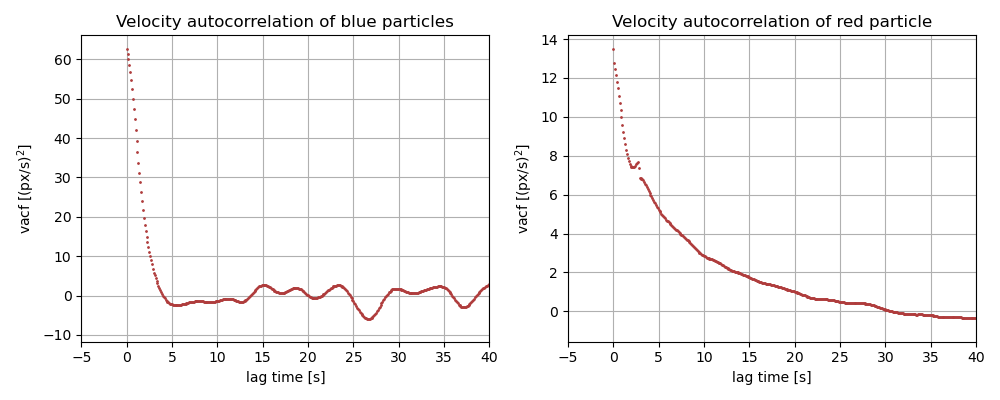

In [38]:
vacf_mean_blue, vacf_std_blue = ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)
vacf_mean_red, vacf_std_red = ys.vacf(redTraj, time_avg=True, lag=maxLagtime)

fig = plt.figure()
plt.subplot(121)
plt.title("Velocity autocorrelation of blue particles")
yg.plot_vacf(vacf_mean_blue, dt = 1/10, lag = maxLagtime, show = False, log_inset=False, marker='o', markersize=1, y_units ='(px/s)^2')
plt.xlim(-5, 40)
plt.subplot(122)
plt.title("Velocity autocorrelation of red particle")
yg.plot_vacf(vacf_mean_red, dt = 1/10, lag = maxLagtime, show = False, log_inset=False, marker='o', markersize=1, y_units ='(px/s)^2')
plt.xlim(-5, 40)
plt.tight_layout()
plt.show()

## Windowed

In [42]:
vacf_blue_windowed = []
vacf_red_windowed = []

for k in tqdm(range(nSteps)):
    trajs = rawTrajs.loc[rawTrajs.frame.between(startFrames[k], endFrames[k])]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i != red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            redTraj.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))
        if i == red_particle_idx:
            p = trajs.loc[trajs.particle==i, ["x","y"]]
            blueTrajs.append(Trajectory(p.x, p.y, dt = 1/10, traj_id=i))

    vacf_blue_windowed.append(ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)[0])
    vacf_red_windowed.append(ys.vacf(redTraj, time_avg=True, lag=maxLagtime)[0])
    

 89%|████████▉ | 258/289 [35:28<05:12, 10.09s/it]

In [ ]:
pd.save_csv(vacf_blue_windowed, "../data/csv/vacf_blue_windowed.csv")
pd.save_csv(vacf_blue_windowed, "../data/csv/vacf_red_windowed.csv")

In [ ]:
fig = plt.figure(figsize=(8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    line.set_ydata(vacf_blue_windowed[step])
    title.set_text(f"{startFrames[step]/10} - {endFrames[step]/10} seconds")
    line1.set_ydata(vacf_red_windowed[step])
    return line, line1,

ax = fig.add_subplot(211)
title = ax.set_title(f"{startFrames[0]/10} - {endFrames[0]/10} seconds")
line, = ax.plot(, vacf_blue_windowed[0])
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-5, 40))
ax.grid()

ax1 = fig.add_subplot(212)
line1, = ax1.plot(, vacf_red_windowed[0])
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-5, 40))
ax1.grid()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
ani.save('../results/vacf_windowed.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.close()

# Other Metrics

In [ ]:
kurt_ref_blue = ys.kurtosis_reference(blueTrajs)
kurt_mean_blue, _ = ys.kurtosis(blueTrajs, time_avg=True, lag=maxLagtime)

kurt_ref_red = ys.kurtosis_reference(redTraj)
kurt_mean_red, _ = ys.kurtosis(redTraj, time_avg=True, lag=maxLagtime)

In [ ]:
fig, ax = plt.subplots()
plt.subplot(121)
yg.plot_kurtosis(kurt_mean_blue, kurtosis_ref=kurt_ref_blue, dt=1/10, show=False)
plt.subplot(122)
yg.plot_kurtosis(kurt_mean_red, kurtosis_ref=kurt_ref_red, dt=1/10, show=False)
plt.show()

In [ ]:
psd_mean_blue, psd_std_blue, frec_blue = ys.psd(blueTrajs, lag=maxLagtime)
psd_mean_red, psd_std_red, frec_red = ys.psd(redTraj, lag=maxLagtime)
fig = plt.figure()
plt.subplot(121)
yg.plot_psd(psd_mean_blue, frec_blue, psd_std_blue, show=False)
plt.subplot(122)
yg.plot_psd(psd_mean_red, frec_red, psd_std_red, show=False)
plt.show()

# Radial Distribution Function


The radial distribution function in 2D is:
$$ g_2(r) = \frac{n(r)}{\pi [(r+\delta r)^2 - r^2 ] \rho} $$

where the density is $\rho = N/V $ and the number density $n(r)$ is computed (using a KDTree data structure) by taking the number of elements closer than $r + \delta r$ minus the number of elements closer than $r$

In 3D (i think):
$$ S_r = 4 \pi r^2 g_2(r) $$

in 2D ???

In [ ]:
@joblib.delayed
def computeRadialDistributionFunction(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)

    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        
        n1 = 0
        for j in a:
            n1 += len(j) - 1

        n2 = 0
        for j in b:
            n2 += len(j) - 1
        
        avg_n[i] = n1/len(a) - n2/len(b)

    g2 = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return g2

In [ ]:
dr = 5
rDisk = 822/2
rList = np.arange(0, 2*rDisk, 1)
rho = nDrops/(np.pi*rDisk**2) # nDrops -1 !

COORDS = np.array(rawTrajs.loc[:,["x","y"]])

In [ ]:
parallel = joblib.Parallel(n_jobs = -2)
frames = 200
trial = parallel(
    computeRadialDistributionFunction(frame, COORDS, rList, dr, rho)
    for frame in tqdm( range(frames) )
)
trial = np.array(trial)

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, trial[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(trial[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(trial[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, frames), interval=20, blit=False)
plt.show()

### RDF analysis with full dataset already computed

In [ ]:
g2 = np.array(pd.read_csv("/Users/matteoscandola/thesis/data/g2.csv"))

In [ ]:
g2.shape

In [ ]:
g_plot = g2[::30, :].T

timearr = np.linspace(0, 30000, 10)/10
timearr = timearr.astype(int)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
img = ax.imshow(np.log(1 + g_plot))
ax.set_xticks(np.linspace(0, g_plot.shape[1], 10))
ax.set_yticks(np.linspace(0, g_plot.shape[0], 10))
ax.set_xticklabels(timearr)
ax.set_yticklabels(np.linspace(0, 2*rDisk, 10).astype(int))
fig.colorbar(img)
plt.xlabel("Time [s]")
plt.ylabel("r [px]")
plt.title("$Log(1 + g_2)$ heatmap ")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(rList, np.mean(g2, axis = 0), yerr = np.std(g2, axis = 0), marker = ".")
#ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

#### Moving averages

In [ ]:
# axis = 0 --> Time moving average
# axis = 1 --> Radius moving average
def running_mean_uniform_filter1d(x, N, AX):
    return uniform_filter1d(x, N, mode='constant', axis = AX, origin=-(N//2))#[:-(N-1)]

##### r-averaged

In [ ]:
g2_r_avg = running_mean_uniform_filter1d(g2, 5, 1)

In [ ]:
fig, ax = plt.subplots()
#ax.plot(rList, g2_r_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_r_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_r_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, 30000, 5), interval=2, blit=False)
plt.show()

In [ ]:
g2_r_avg.shape
g2.shape

In [ ]:
nFrames = 30000
rmax = np.zeros(nFrames)
rmax_r_avg = np.zeros(nFrames)

rMin = 200

for i in range(nFrames):
    rmax[i] = rList[np.where(g2[i]==0)[0][np.where(g2[i]==0)[0]>rMin][0]]
    rmax_r_avg[i] = rList[np.where(g2_r_avg[i]==0)[0][np.where(g2_r_avg[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_r_avg)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

##### time averaged 

In [ ]:
g2_time_avg = running_mean_uniform_filter1d(g2, 50, 0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(rList, g2_time_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_time_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_time_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(25000, nFrames), interval=2, blit=False)
#ani.save(f'/Users/matteoscandola/thesisData/rolled2.mp4', writer=writervideo)
#plt.show()

In [ ]:
rmax = np.zeros(nFrames)
rmax_roll = np.zeros(nFrames)

rMin = 450

for i in range(nFrames):
    rmax[i] = rList[np.where(g_2[i]==0)[0][np.where(g_2[i]==0)[0]>rMin][0]]
    rmax_roll[i] = rList[np.where(g_2_roll[i]==0)[0][np.where(g_2_roll[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_roll)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

## Distance from centre of mass distribution with pca ??

In [ ]:
frame = 0
covMatrix = np.cov(COORDS[frame*nDrops:(frame+1)*nDrops,:])
trace_of_covMatrix = np.trace(covMatrix)
eigenvalues, _ = np.linalg.eigh(covMatrix)
#eigenvalues = np.sort(eigenvalues)[::-1]
#diagCovMatrix = np.diag(eigenvalues)
info = np.zeros(len(eigenvalues))
for i in range(len(eigenvalues)):
    info[i] = np.sum(np.sum(eigenvalues[:i]))
info /= trace_of_covMatrix